# <b> OPAL to sdds converter
be sure to set the PYTHONPATH environment as ```export PYTHONPATH=/lstr/sahara/aard/philippe/codes/pyOPALTools/:$PYTHONPATH```

In [1]:
import sys 
import subprocess
from matplotlib import rc
import os 
sys.path.insert(0, '/lstr/sahara/aard/philippe/codes/pelegant_metis/elegant-tools')
import numpy as np
import matplotlib.pyplot as plt
import eleganttool
from IPython.display import display, Markdown
import opal 
# install directories for PELEGANT and SDDS tools (should not be needed)
sddspath='/lstr/sahara/aard/philippe/codes/pelegant_metis/epics/extensions/bin/linux-x86_64/'
appspath='/lstr/sahara/aard/philippe/codes/pelegant_metis/oag/apps/bin/linux-x86_64/'

FontSize=16
          
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('xtick',labelsize=FontSize)
rc('ytick',labelsize=FontSize)
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('font', size = FontSize)

PWD=subprocess.run('pwd',stdout=subprocess.PIPE)
PWD.stdout

b'/lstr/sahara/aard/philippe/anl_awa_hghe/tracking-strhd/elegant\n'

In [19]:
# take data at a screen (where particle cross the screen at fix z)
direc ='/lstr/sahara/aard/philippe/anl_awa_hghe/straightAhead/elegant/'
scrn  = 'YAG4.h5'

In [26]:
# take data from a phase-space dump
#scrn  = 'input200k.h5'

In [27]:
coord = opal.load_dataset('./',fname=scrn)
print(coord)




	H5 dataset.

	Number of steps: 43

	Available step attributes (28):

	#sigma              
	#varepsilon         
	#varepsilon-geom    
	B-ref               
	CHARGE              
	E-ref               
	ENERGY              
	GlobalTrackStep     
	LocalTrackStep      
	MASS                
	MEANP               
	NumBunch            
	OPAL_flavour        
	RMSP                
	RMSX                
	RefPartP            
	RefPartR            
	SPOS                
	Step                
	SteptoLastInj       
	TIME                
	TaitBryantAngles    
	centroid            
	dE                  
	maxP                
	maxX                
	minP                
	minX                


	Available step datasets (10):

	id                  
	porigin             
	ptype               
	px                  
	py                  
	pz                  
	q                   
	x                   
	y                   
	z                   



In [28]:
#coord.plot_phase_space('time', 'x', xsci=True, ysci=True)
# bugg in ENERGY parameter ouput from the hdf5 file ? 
Step=-1
meanp          = coord.getData('MEANP', step=0)
betagamma_mean = np.sqrt(np.sum(meanp[0,:]**2))
gamma_mean     = np.sqrt(1+betagamma_mean**2)
x  = coord.getData('x', step=Step)
px = coord.getData('px', step=Step)
y  = coord.getData('y', step=Step)
py = coord.getData('py', step=Step)
t  = coord.getData('time', step=Step)  # not define for the phase-space dump
z  = coord.getData ('z',step=Step)     # meaningless for a screen output
pz = coord.getData('pz', step=Step)
id = coord.getData('id', step=Step)
qm = coord.getData('q', step=Step)
print(len(id))
A  = np.vstack((x,px/pz,y, py/pz, t, np.sqrt(px**2+py**2+pz**2),id))
np.shape(A)

print ('total charge:',sum(qm))


199999
total charge: -4.999974999989523e-09


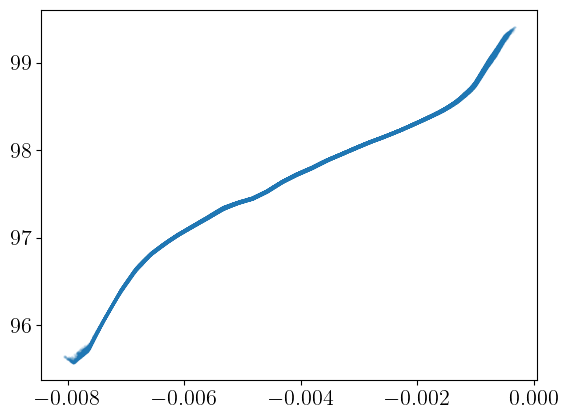

In [29]:
# check tiome versus z 
plt.plot (z,pz,'.',markersize=1,alpha=0.1)

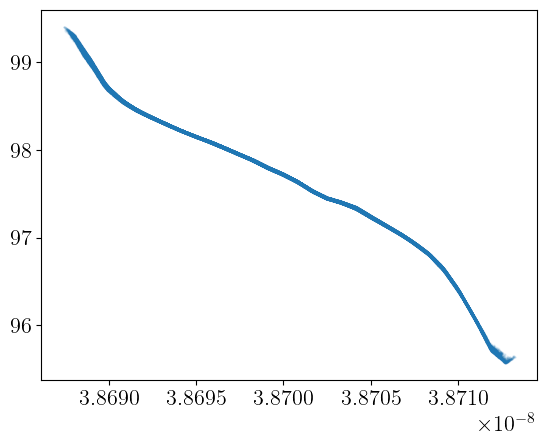

In [24]:
plt.plot (t,pz,'.',markersize=1,alpha=0.1)

In [132]:
def writeT(file, a):
    """Write a two-dim. NumPy array a in tabular form."""
    print('writing ...')
    if len(a.shape) > 2:
        raise TypeError("a 2D array is required, shape now is "+str(a.shape))
    else:
        if len(a.shape) == 2:
            for i in range(a.shape[0]):
                for j in range(a.shape[1]):
                    s=str(a[i,j])+"\t"
#                    s=" %12.5e" % a[i,j]
                    file.write(s)
                file.write("\n")
        else:
            for i in range(a.shape[0]):
                s="%2.10g\n" % a[i]
                file.write(s)
    print('done.')


In [141]:
def dump_sdds(coord, fname):
        """
          write a sdds ELEGANT-compliant file using the data coord
        """
        meanp    = coord.getData('MEANP', step=0)
        betagamma_mean = np.sqrt(np.sum(meanp[0,:]**2))
        qBunch   = coord.getData('TotalCharge', step=0)[0,0]
        x  = coord.getData('x', step=0)
        px = coord.getData('px', step=0)
        y  = coord.getData('y', step=0)
        py = coord.getData('py', step=0)
        t  = coord.getData('time', step=0)
        pz = coord.getData('pz', step=0)
        id = 1+np.arange(len(t))
        # issue with ID coord.getData('id', step=0)

        t = t -t.mean()
        numPart = len(id)
        A  = np.vstack((x,px/pz,y, py/pz, t, np.sqrt(px**2+py**2+pz**2),id))
        A[6,:]=A[6,:].astype('int')
        x = coord.getData('x', step=0)
        f=open(fname,'w');
        f.write("SDDS1\n")
#        f.write("&parameter name=Step, description=\"Simulation step\", type=long, &end \n")
#        f.write("&parameter name=pCentral, symbol=\"p$bcen$n\", units=\"m$be$nc\", description=\"Reference beta*gamma\", type=double, &end\n")
#        f.write("&parameter name=Charge, units=C, description=\"Beam charge\", type=double, &end\n")
#        f.write("&parameter name=Particles, description=\"Number of particles\", type=long, &end\n")
        f.write("&column name=x, units=m, type=double, &end \n")
        f.write("&column name=xp, type=double,   &end \n")
        f.write("&column name=y, units=m, type=double,  &end \n")
        f.write("&column name=yp, type=double,  &end \n")
        f.write("&column name=t, units=s, type=double,  &end \n")
        f.write("&column name=p, type=double, units=\"m$be$nc\" &end \n")
        f.write("&column name=particleID, type=long,  &end \n")
        f.write("&data mode=ascii, &end \n")
        f.write("! page number 1 \n") # this is the simulation step 
#        f.write(str(gamma_mean)+"\n") #  reference energy (bunch average)
#        f.write(str(qBunch)+"\n")
        f.write(str(numPart)+"\n")
#        f.write(str(numPart)+"\n") # this is the number of lines
        writeT(f,A.T);
        f.close()



In [142]:
dump_sdds(coord,'yag4opal.sdds')
# do a sddsconvert -binary yag4opal.sdds cath2yag4.sdds as Pelegant wants binary inputs


writing ...
done.


&sdds_beam
        input = "cath2yag4.sdds"
        input_type = "elegant"
        sample_interval = 1
&end

&track
&end
